# Ecological example of high-order "epistasis"

Imports for the notebook below.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from gpmap.utils import mutations_to_genotypes

from gpmap import GenotypePhenotypeMap

from epistasis.matrix import get_model_matrix
from epistasis.models import EpistasisLinearRegression
from epistasis.pyplot import plot_coefs

$$
F_{total} = \text{community phenotype (total metabolism?)} \\
s_{i} = species_{i} \\
$$

$$
\alpha_{i} = \text{metabolic rate of species i on resource A} \\ 
\beta_{i} = \text{metabolic rate of species i on resource B} \\ 
\gamma_{i} = \text{metabolic rate of species i on resource C} \\ 
$$

$$
F_{A} = \text{community phenotype for resource A (total metabolism of resource A)} \\
F_{B} = \text{community phenotype for resource B (total metabolism of resource B)} \\
F_{C} = \text{community phenotype for resource C (total metabolism of resource C)} \\
$$

Model the total phenotype as the expected value from an average of individual phenotypes for each resource--Something like a free energy. 
$$
F_{total} = -ln \left( \frac{P(\text{A})}{P(\text{Not A})} \right)
$$

If we treat the probability distribution of the states as a Boltzmann distribution, we get: 

$$
F_{total} = -ln \left( \frac{e^{-F_A}}{e^{-F_B} + e^{-F_C} } \right)
$$

which reduces to:
$$
F_{total} = F_{A} + ln(F_{B} + F_{C})
$$

The log term is clearly additive. So, if our observed phenotypes truly is a average over a bunch of states, we should expect to observe high-order epistasis.

Let's simulate this scenario.

In [205]:
n_species = 5

# Define metabolic rates for each species in each state (3-states total).
alpha = np.random.rand(n_species)
beta = np.random.rand(n_species) * 10
gamma = np.random.rand(n_species) * 1

We'll construct a list of possible communities and a community matrix.

In [206]:
# Book-keeping code.
no_communities = '0'*n_species
species = {i: ['0', '1'] for i in range(n_species)}

# Enumerate all possible communities.
communities = mutations_to_genotypes(no_communities, species)

# Construct a "community" matrix: 0 if microbe is present in community, 1 if not.
coefs = [[i] for i in range(1, n_species+1)]
community_matrix = get_model_matrix(communities, coefs, model_type='local')

print("community list:")
print(communities)
print("")
print("community matrix: ")
print(community_matrix)

community list:
['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']

community matrix: 
[[0 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 1 1]
 [0 0 1 0 0]
 [0 0 1 0 1]
 [0 0 1 1 0]
 [0 0 1 1 1]
 [0 1 0 0 0]
 [0 1 0 0 1]
 [0 1 0 1 0]
 [0 1 0 1 1]
 [0 1 1 0 0]
 [0 1 1 0 1]
 [0 1 1 1 0]
 [0 1 1 1 1]
 [1 0 0 0 0]
 [1 0 0 0 1]
 [1 0 0 1 0]
 [1 0 0 1 1]
 [1 0 1 0 0]
 [1 0 1 0 1]
 [1 0 1 1 0]
 [1 0 1 1 1]
 [1 1 0 0 0]
 [1 1 0 0 1]
 [1 1 0 1 0]
 [1 1 0 1 1]
 [1 1 1 0 0]
 [1 1 1 0 1]
 [1 1 1 1 0]
 [1 1 1 1 1]]


Calculate phenotypes for each community and resource. 

Then calculate the total phenotype as the average of states.

In [207]:
# Simple dot product of matrix and metabolic rates.
F_A = community_matrix @ alpha
F_B = community_matrix @ beta
F_C = community_matrix @ gamma

# Probability of each state (boltzmann distributed).
P_A = np.exp(-F_A)
P_B = np.exp(-F_B)
P_C = np.exp(-F_C)

# Total phenotype.
F_total = np.log(P_A /(P_B + P_C))

Construct a useful mapping object to be used by epistasis model.

In [208]:
gpm = GenotypePhenotypeMap(
    wildtype = no_communities,
    genotypes = communities,
    phenotypes = F_total,
    mutations = species,
)

In [211]:
m = EpistasisLinearRegression(order=3, model_type='global')
m.add_gpm(gpm)
m.fit()
print(m.score())

m.epistasis.data

0.9857888924513231


,sites,values
0,[0],-0.209335
1,[1],0.162319
2,[2],0.255879
3,[3],-0.072213
4,[4],-0.138244
5,[5],-0.147016
6,"[1, 2]",-0.025004
7,"[1, 3]",-0.024912
8,"[1, 4]",-0.017469
9,"[1, 5]",-0.024729


(<Figure size 288x360 with 2 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a203b4b38>])

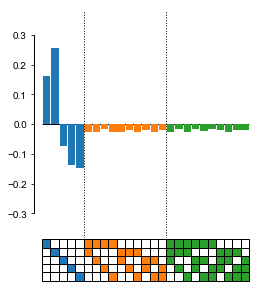

In [213]:
plot_coefs(m, figsize=(4,5))

## Fit an ensemble model.

In [204]:
from epistasis.models.ensemble import EpistasisEnsembleRegression

In [198]:
m = EpistasisEnsembleRegression(nstates=4)
m.add_gpm(gpm)
m.fit()

EpistasisEnsembleRegression(nstates=4, order=1)

In [199]:
m.score()

0.9809552184815908